In [ ]:
import os
import numpy as np 
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd '/content/gdrive/My Drive/pokepredict/types'

/content/gdrive/My Drive/pokepredict/types


In [ ]:
df_train = pd.read_csv("data/type_encodings.csv")
print(df_train.shape)
df_train.head()

(8430, 19)


,file,type_Bug,type_Dark,type_Dragon,type_Electric,type_Fairy,type_Fighting,type_Fire,type_Flying,type_Ghost,type_Grass,type_Ground,type_Ice,type_Normal,type_Poison,type_Psychic,type_Rock,type_Steel,type_Water
0,0001.png,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,0002.png,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,0003.png,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,0004.png,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0005.png,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
target_cols = df_train.drop(['file'], axis=1).columns.to_list()

number_classes = len(target_cols)
image_size = 200
number_epochs = 20

batch_size = 32

target_cols

['type_Bug',
 'type_Dark',
 'type_Dragon',
 'type_Electric',
 'type_Fairy',
 'type_Fighting',
 'type_Fire',
 'type_Flying',
 'type_Ghost',
 'type_Grass',
 'type_Ground',
 'type_Ice',
 'type_Normal',
 'type_Poison',
 'type_Psychic',
 'type_Rock',
 'type_Steel',
 'type_Water']

In [ ]:
def build_decoder(with_labels=True, target_size=(image_size, image_size)):
    def decode(path):
        file_bytes = tf.io.read_file(path)

        image = tf.image.decode_png(file_bytes, channels=3)
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.image.resize(image, target_size)
        
        return image
    
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    
    return decode_with_labels if with_labels else decode

In [ ]:
def build_dataset(paths, labels=None, bsize=32, decode_function=None):
    if decode_function is None:
        decode_function = build_decoder(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dataset = tf.data.Dataset.from_tensor_slices(slices)  
    dataset = dataset.map(decode_function, num_parallel_calls=AUTO)

    dataset = dataset.batch(bsize).prefetch(AUTO) 

    return dataset

In [ ]:
load_dir = "data/images/"

train_paths = load_dir + df_train['file']

label_cols = df_train.columns[1:]
labels = df_train[label_cols].values

labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, labels, test_size=0.2, random_state=42)

In [ ]:
decoder = build_decoder(with_labels=True, target_size=(image_size, image_size))

data_train = build_dataset(train_paths, train_labels, bsize=batch_size, decode_function=decoder)
data_valid = build_dataset(valid_paths, valid_labels, bsize=batch_size, decode_function=decoder)

In [ ]:
net = EfficientNetB0(include_top=False, input_shape=(image_size, image_size, 3), weights='imagenet')

output = net.output
output = Dropout(0.75)(output)
output = GlobalAveragePooling2D()(output)
output = Dropout(0.75)(output)
output = Dense(number_classes, activation='sigmoid')(output)

model = Model(inputs=net.input, outputs=output)
model.compile(Adam(lr=0.0005), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(multi_label=True, name='auc')])

In [ ]:
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_delta = 1e-4, min_lr = 1e-6, mode = 'min')
        
ckp = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        
es = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, mode='min', restore_best_weights=True, verbose=1)

In [ ]:
history = model.fit(data_train,                      
                    validation_data=data_valid,                                       
                    epochs=number_epochs,
                    callbacks=[rlr,es,ckp],
                    shuffle=True,
                    verbose=1)

Epoch 1/20
211/211 [==============================] - 94s 401ms/step - loss: 0.4090 - auc: 0.5779 - val_loss: 0.2739 - val_auc: 0.5017

Epoch 00001: val_loss improved from inf to 0.27386, saving model to model.h5
Epoch 2/20
211/211 [==============================] - 78s 368ms/step - loss: 0.1616 - auc: 0.8877 - val_loss: 0.2649 - val_auc: 0.6669

Epoch 00002: val_loss improved from 0.27386 to 0.26492, saving model to model.h5
Epoch 3/20
211/211 [==============================] - 78s 368ms/step - loss: 0.0954 - auc: 0.9560 - val_loss: 0.2468 - val_auc: 0.8038

Epoch 00003: val_loss improved from 0.26492 to 0.24683, saving model to model.h5
Epoch 4/20
211/211 [==============================] - 78s 368ms/step - loss: 0.0646 - auc: 0.9782 - val_loss: 0.3155 - val_auc: 0.6092

Epoch 00004: val_loss did not improve from 0.24683
Epoch 5/20
211/211 [==============================] - 78s 370ms/step - loss: 0.0478 - auc: 0.9845 - val_loss: 0.2885 - val_auc: 0.6939

Epoch 00005: ReduceLROnPlateau

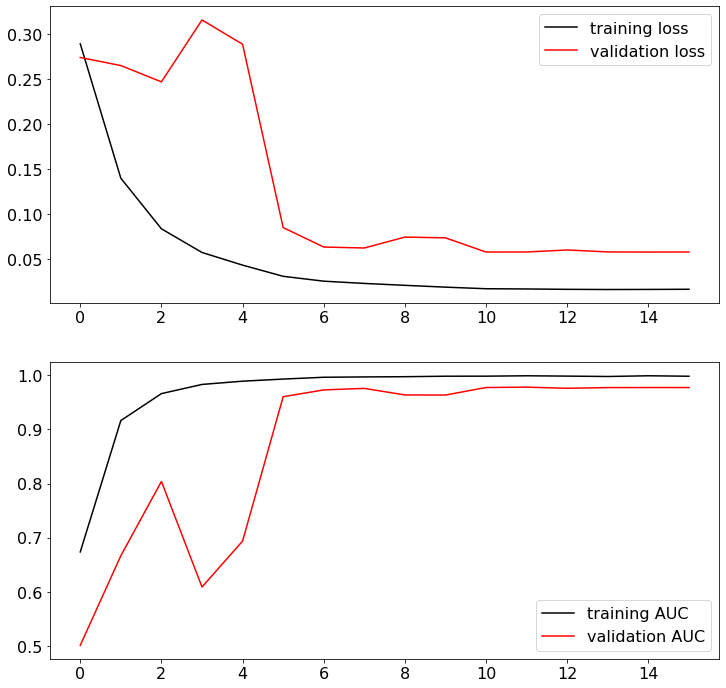

In [ ]:
plt.rcParams.update({'font.size': 16})
hist = pd.DataFrame(history.history)
fig, (ax1, ax2) = plt.subplots(figsize=(12,12),nrows=2, ncols=1)

hist['loss'].plot(ax=ax1, c='k', label='training loss')
hist['val_loss'].plot(ax=ax1, c='r', label='validation loss')
ax1.legend()

hist['auc'].plot(ax=ax2, c='k', label='training AUC')
hist['val_auc'].plot(ax=ax2, c='r', label='validation AUC')
ax2.legend()

plt.show()